In [24]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [25]:
import numpy as np
import pandas as pd

In [26]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [27]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [28]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [29]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [30]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [31]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [32]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

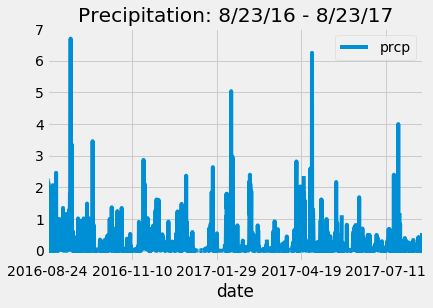

In [33]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
latestDate = (session.query(Measurement.date)
                     .order_by(Measurement.date.desc())
                     .first())

#extract string from query object
latestDate = list(np.ravel(latestDate))[0]
#convert date string to datetime object
latestDate = dt.datetime.strptime(latestDate, '%Y-%m-%d')

#extract year, month, and day as integers
latestYear = int(dt.datetime.strftime(latestDate, '%Y'))
latestMonth = int(dt.datetime.strftime(latestDate, '%m'))
latestDay = int(dt.datetime.strftime(latestDate, '%d'))


# Calculate the date 1 year ago from the last data point in the database
yearBefore = dt.date(latestYear, latestMonth, latestDay) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
rainData = (session.query(Measurement.date, Measurement.prcp)
                  .filter(Measurement.date > yearBefore)
                  .order_by(Measurement.date)
                  .all())

# Save the query results as a Pandas DataFrame and set the index to the date column
rainTable = pd.DataFrame(rainData)
rainTable = rainTable.set_index('date')

# Sort the dataframe by date
rainTable = rainTable.sort_index(ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
rainTable.plot(title="Precipitation: 8/23/16 - 8/23/17")

In [34]:
# Use Pandas to calcualte the summary statistics for the precipitation data
rainTable.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [35]:
# Design a query to show how many stations are available in this dataset?
stationsCount = session.query(Station).count()
stationsCount

9

In [36]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stationCounts = (session.query(Measurement.station, func.count(Measurement.station))
                        .group_by(Measurement.station)
                        .order_by(func.count(Measurement.station).desc())
                        .all())
stationCounts

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [37]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
stationID = stationCounts[0][0]

#lowest temperature
lowestTemp = (session.query(Measurement.tobs)
                     .filter(Measurement.station == stationID)
                     .order_by(Measurement.tobs.asc())
                     .first())
lowestTemp = lowestTemp[0]


#highest temperature
highestTemp = (session.query(Measurement.tobs)
                      .filter(Measurement.station == stationID)
                      .order_by(Measurement.tobs.desc())
                      .first())
highestTemp = highestTemp[0]

#average temperature
avgTemp = (session.query(func.avg(Measurement.tobs))
                  .filter(Measurement.station == stationID))
avgTemp = '{0:.3}'.format(avgTemp[0][0])

print(f"The lowest temperature is {lowestTemp} degrees Farenheit.")
print(f"The highest temperature is {highestTemp} degrees Farenheit.")
print(f"The average temperature is {avgTemp} degrees Farenheit.")

The lowest temperature is 54.0 degrees Farenheit.
The highest temperature is 85.0 degrees Farenheit.
The average temperature is 71.7 degrees Farenheit.


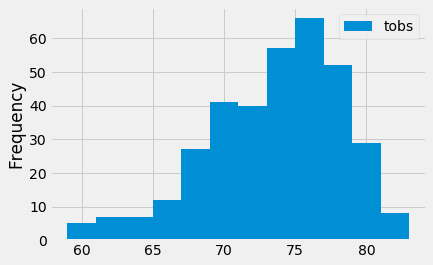

In [38]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

#query for the last year of temperature data
tempData = (session.query(Measurement.date, Measurement.tobs)
                   .filter(Measurement.date > yearBefore)
                   .filter(Measurement.station == stationID)
                   .order_by(Measurement.date)
                   .all())

#convert to data frame
tempTable = pd.DataFrame(tempData)
tempTable = tempTable.set_index('date')

#sory by date
tempTable = tempTable.sort_index(ascending=True)

#histogram plot with pandas
tempTable.plot(kind='hist', bins=12)

In [39]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [40]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
#set trip dates and previous dates
trip = '2019-04-08 to \n 2019-04-19'
tripStartDate = '2017-04-08'
tripEndDate = '2017-04-19'

#calculate the tmin, tavg, and tmax 
tripTemps = calc_temps(tripStartDate, tripEndDate)

tripTemps

[(67.0, 73.6, 83.0)]

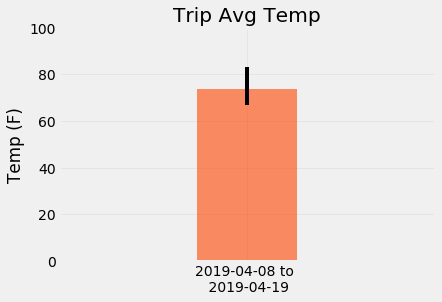

In [41]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

minTripTemp = tripTemps[0][0]
avgTripTemp = tripTemps[0][1]
maxTripTemp = tripTemps[0][2]

minError = avgTripTemp - minTripTemp
maxError = maxTripTemp - avgTripTemp

errorBars = np.array([[minError], [maxError]])

plt.bar(trip, avgTripTemp, yerr=errorBars, color = 'orangered', alpha = .6)
plt.ylim(0, 100)
plt.xlim(-1.5, 1.5)
plt.title('Trip Avg Temp')
plt.ylabel('Temp (F)')
plt.grid(alpha=.3)

In [42]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

sel = ([Station.station, 
        Station.name, 
        func.sum(Measurement.prcp), 
        Station.latitude, 
        Station.longitude, 
        Station.elevation
       ])

stationRain = (session.query(*sel)
                   .filter(Station.station == Measurement.station)
                   .filter(Measurement.date >= tripStartDate)
                   .filter(Measurement.date <= tripEndDate)
                   .group_by(Station.station)
                   .order_by(func.sum(Measurement.prcp).desc())
                   .all())

#convert query object to data frame
stationRainTable = pd.DataFrame(np.array(stationRain))
#rename columns
stationRainTable = stationRainTable.rename(columns={0: "Station", 1: "Location", 
                                                    2: "Total Precipitation", 3: "Latitude", 
                                                    4: "Longitude", 5: "Elevation"})

stationRainTable

,Station,Location,Total Precipitation,Latitude,Longitude,Elevation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",7.38,21.3331,-157.8025,152.4
1,USC00519281,"WAIHEE 837.5, HI US",6.979999999999999,21.45167,-157.84888999999998,32.9
2,USC00513117,"KANEOHE 838.1, HI US",2.48,21.4234,-157.8015,14.6
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",0.86,21.5213,-157.8374,7.0
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",0.8099999999999999,21.33556,-157.71139,19.5
5,USC00519397,"WAIKIKI 717.2, HI US",0.31000000000000005,21.2716,-157.8168,3.0
6,USC00517948,"PEARL CITY, HI US",0.0,21.3934,-157.9751,11.9


## Optional Challenge Assignment

In [43]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [44]:
# calculate the daily normals for your trip
# Set the start and end date of the trip
startDate = "2019-04-08"
endDate = "2019-04-19"

# Use the start and end date to create a range of dates
startNum = int(startDate[-2:])
endNum = int(endDate[-2:])
tripLength = endNum - startNum + 1

# Stip off the year and save a list of %m-%d strings
startDate = dt.datetime.strptime(startDate, '%Y-%m-%d')

dateList = [dt.datetime.strftime(startDate + dt.timedelta(days = x), '%m-%d') 
            for x in range(0, tripLength)]

# Loop through the list of %m-%d strings and calculate the normals for each date
tripNormals = [daily_normals(date) for date in dateList]

tripNormals

[[(66.0, 72.10526315789474, 77.0)],
 [(62.0, 71.6140350877193, 78.0)],
 [(64.0, 71.40350877192982, 79.0)],
 [(65.0, 72.49180327868852, 82.0)],
 [(65.0, 72.22413793103448, 80.0)],
 [(64.0, 71.52542372881356, 79.0)],
 [(65.0, 72.75, 81.0)],
 [(61.0, 71.79310344827586, 79.0)],
 [(62.0, 71.55357142857143, 81.0)],
 [(65.0, 71.93103448275862, 77.0)],
 [(67.0, 72.49152542372882, 77.0)],
 [(65.0, 72.42105263157895, 83.0)]]

In [45]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
tripNormals = [np.array(normal[0]) for normal in tripNormals]

#convert normals list into a data frame
normalsTable = pd.DataFrame(tripNormals)
#add date column
normalsTable["Date"] = dateList
#set index and rename columns
normalsTable = normalsTable.set_index("Date")
normalsTable = normalsTable.rename(columns={0: "Low Temp", 1: "Avg Temp", 2: "High Temp"})

normalsTable

,Low Temp,Avg Temp,High Temp
Date,,,
04-08,66.0,72.105263,77.0
04-09,62.0,71.614035,78.0
04-10,64.0,71.403509,79.0
04-11,65.0,72.491803,82.0
04-12,65.0,72.224138,80.0
04-13,64.0,71.525424,79.0
04-14,65.0,72.750000,81.0
04-15,61.0,71.793103,79.0
04-16,62.0,71.553571,81.0


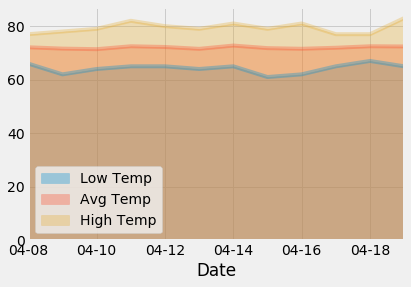

In [46]:
# Plot the daily normals as an area plot with `stacked=False`
normalsTable.plot.area(stacked=False, alpha=.333)